## Carga Bibliotecas

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 7.6 MB/s 


In [3]:
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
#xgboost
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
#from nltk.stem import WordNetLemmatizer

# Word2vec
import gensim
from gensim.models import Word2Vec


# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

#plot
import seaborn
seaborn.set(style='whitegrid')

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
DATASET_ENCODING = "ISO-8859-1"

SEQUENCE_LENGTH = 600

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.45, 0.65)

# EXPORT
KERAS_MODEL2 = "/content/drive/MyDrive/Mercantil/modelos_analisis_de_sentimiento/model2.h5"
WORD2VEC_MODEL2 = "/content/drive/MyDrive/Mercantil/modelos_analisis_de_sentimiento/model2.w2v"
TOKENIZER_MODEL2 = "/content/drive/MyDrive/Mercantil/modelos_analisis_de_sentimiento/tokenizer2.pkl"
ENCODER_MODEL2 = "/content/drive/MyDrive/Mercantil/modelos_analisis_de_sentimiento/encoder2.pkl"

## Carga modelo de palabras

In [5]:

w2v_model = Word2Vec.load(WORD2VEC_MODEL2)

Pregunta vocabulario

In [6]:
w2v_model.most_similar("preguntar")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('cuanto', 0.20416417717933655),
 ('atender', 0.19889956712722778),
 ('quitar', 0.18140551447868347),
 ('ultimo', 0.18115881085395813),
 ('anterior', 0.17987485229969025),
 ('probar', 0.17966651916503906),
 ('malavilloso', 0.17404069006443024),
 ('gustar', 0.17380136251449585),
 ('online', 0.16924507915973663),
 ('iniciar', 0.16756120324134827)]

# Modelo análisis de sentimiento

### Cargar modelo análisis de Sentimiento

In [7]:
file = open(ENCODER_MODEL2,'rb')
file.seek(0)
tokenizer = pickle.load(file)
file.close()

In [8]:
with open(TOKENIZER_MODEL2, 'rb') as handle:
    tokenizer = pickle.load(handle)

Debe aparecer: <keras_preprocessing.text.Tokenizer at ...>


In [9]:
tokenizer

In [10]:
model = load_model(KERAS_MODEL2)

Si quiere incluir clasificación neutral cambia True

In [26]:
def decode_sentiment(score, include_neutral):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [12]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

## Clasificación Comentarios

### **Cargar Herramientas**

In [13]:
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
#from nltk.stem import WordNetLemmatizer

#Replace all non alphabets
from unidecode import unidecode

#For lematization
import spacy


In [14]:
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = stopwords.words("spanish")
stemmer = SnowballStemmer("spanish")#extrae la raíz de una palabra
!spacy download es
lematiza = spacy.load("es_core_news_sm")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


2022-08-23 15:15:20.225904: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
⚠ As of spaCy v3.0, shortcuts like 'es' are deprecated. Please use the
full pipeline package name 'es_core_news_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.9 MB 8.6 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [15]:
stop_words.extend(['ye','para','irrtificar','santiaguir','e','xhlz','zon','qie','sexy','bta','zuleerma','? ar','saimecripto',
                  'eliar aguilar','gn','mercantilbancouniversal','bancomercantil'])

In [16]:
elimina = ['no','estado','sin','como']
stop_words = [x for x in stop_words if x  not in elimina]

In [18]:
emojis = pd.read_excel('/content/drive/MyDrive/Mercantil/dic_emoji.xlsx')
emojis.set_index('emoji',inplace=True)
emojis = emojis.to_dict()
emojis = emojis['equivale']
print(emojis)

{'😈': 'diablo', '😀': 'sonrisa', '😍': 'encantar', '😄': 'sonrisa', '😂': 'risa', '😉': 'guiño', '😊': 'sonrisa', '🤣': 'risa', '😘': 'beso', '🤡': 'payaso', '👻': 'fantasma', '😆': 'burla', '🥰': 'encantar', '😻': 'encantar', '😋': 'feliz', '😒': 'desagradar', '😓': 'desagradar', '😔': 'triste', '😖': 'triste', '😚': 'beso', '🏦': 'banco', '😜': 'burla', '😝': 'burla', '😞': 'triste', '😠': 'enojo', '😡': 'enojo', '😢': 'triste', '😣': 'frustracion', '😤': 'enojo', '😥': 'preocupacion', '😩': 'frustracion', '😪': 'triste', '😭': 'triste', '😫': 'frustracion', '😰': 'preocupacion', '😳': 'sonrojado', '😸': 'risa', '😹': 'risa', '😺': 'risa', '😿': 'triste', '🙅': 'bloqueo', '🙏': 'rezar', '❤': 'corazon', '👍': 'bien', '👎': 'mal', '👏': 'aplauso', '👪': 'familia', '👿': 'enojado', '💩': 'mierda', '💪': 'fuerza', '😐': 'neutral', '😑': 'serio', '😕': 'confundido', '😟': 'preocupacion', '😧': 'preocupacion', '🌞': 'sol', '🇻🇪': 'venezuela', '😨': 'miedo', '😱': 'miedo', ':)': 'sonrisa', '💜': 'corazon', '💝': 'regalo', '🚗': 'carro', '🚕': 'taxi',

In [17]:
with open('/content/drive/MyDrive/Mercantil/extencion_lematizador') as f:
    palabras = dict(i.rstrip().split(None, 1) for i in f)
print(palabras)

{'madurar': 'maduro', 'clavar': 'clave', 'paginar': 'pagina', 'sera': 'ser', 'seguira': 'seguir', 'divisar': 'divisa', 'lonuevo': 'nuevo', 'deberiar': 'deber', 'cumpliraa+-os': 'cumpleanos', 'nadar': 'nada', 'pudrir': 'poder', 'sii': 'si', 'ye': 'si', 'parir': 'para', 'cariaa+-o': 'carino', 'app': 'aplicacion', 'gracia': 'gracias', 'fallir': 'fallar', 'aa+-os': 'año', 'huma?anaird': 'humanidad', 'linear': 'linea', 'contactarer': 'contactar', 'naciinal': 'nacional', 'ma?anada': 'mañana', 'estarfaeued': 'estar', 'eaa': 'esa', 'quebhay': 'que hay', 'enviir': 'enviar', 'mercanril': 'mercantil', 'estrellar': 'estrella', 'malisimir': 'malo', 'gustariar': 'gustar', 'cencilla': 'sencillo', 'sencillar': 'sencillo', 'agilizarizen': 'agilizar', 'seguo': 'seguro', 'graciasscontar': 'gracias', 'line': 'online', 'objetivar': 'objetivo', 'personar': 'personal', 'colocars': 'colocar', 'presi': 'presidente', 'gnar': 'ganar', 'dejarra': 'dejar', 'aa+-o': 'año', 'nformatico': 'informatico', 'pagin': 'pag

In [21]:
def preprocess(tweet, stem=False):
    
    # Create Lemmatizer and Stemmer.
    #wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    tweet = str(tweet).lower()
        
    # Replace all URls with 'URL'
    tweet = re.sub(urlPattern,' url',tweet)
    # Replace all emojis.
    for emoji in emojis.keys():
      tweet = tweet.replace(emoji, " emoji " + emojis[emoji]+" ")        
    # Replace @USERNAME to 'USER'.
    tweet = re.sub(userPattern,'', tweet)        
    # Replace all non alphabets.
    tweet = unidecode(tweet)
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
    #Lematiza
    tweet = lematiza(tweet)
    lemmas = [tok.lemma_.lower() for tok in tweet]
    tokens = []
    for token in lemmas:
          # Checking if the word is a stopword.
          if token not in stop_words:
            #cheching if word has more than one letter
            for palabra in palabras.keys():
              token = token.replace(palabra, palabras[palabra])
            if len(token)>1:
              if stem:
                tokens.append(stemmer.stem(token))
              else:
                tokens.append(token)
    return " ".join(tokens)


        

### **Predicción Simple**

In [70]:
predict(preprocess("excelente banco gracias pagina gestionar pagar cita"))

{'label': 'NEUTRAL',
 'score': 0.5698418021202087,
 'elapsed_time': 0.2103571891784668}

In [71]:
predict(preprocess('excelente banco paginaa gestionar pagar cita apoyar gracias cuenta dinero'))

{'label': 'NEGATIVE',
 'score': 0.446296364068985,
 'elapsed_time': 0.10437393188476562}

In [ ]:
predict(preprocess("deberia ir a una oficina para cambiar mi numero de telefono?"))

{'elapsed_time': 0.10288190841674805,
 'label': 'NEGATIVE',
 'score': 0.36969226598739624}

In [ ]:
predict(preprocess("Estoy encantada con la atención que recibí"))

{'elapsed_time': 0.11264777183532715,
 'label': 'POSITIVE',
 'score': 0.5575772523880005}

In [ ]:
predict(preprocess("Ayer me depositaron, desde tpago"))

{'elapsed_time': 0.1296708583831787,
 'label': 'POSITIVE',
 'score': 0.7312635183334351}

### **Inspecciona tabla de comentarios**

 Cargar tabla para analizar

In [49]:
df= pd.read_excel('/content/drive/MyDrive/Mercantil/data_class_newV2.1.xlsx')

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5387 entries, 0 to 5386
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    5387 non-null   int64  
 1   Unnamed: 0.1  5387 non-null   int64  
 2   text          5387 non-null   object 
 3   text_process  5387 non-null   object 
 4   true_target   5387 non-null   object 
 5   target        5387 non-null   object 
 6   score         5387 non-null   float64
 7   new_target    5387 non-null   object 
 8   classify      5387 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 378.9+ KB


**Debe tener una columna con nombre 'text'...**
['user_id', 'screen_name', 'created_at', 'text']

**Limpia data**

In [56]:
#df = df.drop(['Unnamed: 0'], axis=1) #elimina alguna columna en especial

In [176]:
#df = df.dropna() #elimina filas con algún valor nulo

In [ ]:
#df = df.drop_duplicates()#elimina duplicados

In [51]:
df.groupby('new_target').count()

,Unnamed: 0,Unnamed: 0.1,text,text_process,true_target,target,score,classify
new_target,,,,,,,,
NEGATIVE,2440,2440,2440,2440,2440,2440,2440,2440
NEUTRAL,1649,1649,1649,1649,1649,1649,1649,1649
POSITIVE,1298,1298,1298,1298,1298,1298,1298,1298


In [52]:
df.head()

,Unnamed: 0,Unnamed: 0.1,text,text_process,true_target,target,score,new_target,classify
0,0,0,"excetente servcio, funciona bien",excetente servcio funcionar bien,POSITIVE,POSITIVE,0.655205,POSITIVE,True_positive
1,1,1,"mercantil es el mejor banco, soy cliente fiel",mercantil ser mejor banco ser cliente fiel,POSITIVE,POSITIVE,0.740379,POSITIVE,True_positive
2,2,2,estoy encantada con la atención que recibi,encantado atencion recibi,POSITIVE,POSITIVE,0.557577,NEUTRAL,"False_neutral, is Positive"
3,3,3,gracias,gracias,POSITIVE,POSITIVE,0.748588,POSITIVE,True_positive
4,4,4,mercantil es mi banco de preferencia,mercantil ser banco preferencia,POSITIVE,POSITIVE,0.683514,POSITIVE,True_positive


In [24]:
#df.reset_index(drop=True,inplace=True) # ordena índice

### **Procesar texto en tabla**

**Agregar columnas que tendrán la clasificación del sentimiento:** Target y Score

In [22]:
def agregar_columnas(comentarios):
  comentarios = comentarios.assign(text_process=np.nan) #para texto lematizado
  comentarios = comentarios.assign(new_target=np.nan) #para clasificación
  comentarios = comentarios.assign(score=np.nan) #para score
  comentarios.head()
  return(comentarios)

In [23]:
#comentarios.text_process = comentarios.text.apply(lambda x: str(x)) #convierte en texto
def procesar_texto(comentarios):
  comentarios.text_process = comentarios.text.apply(lambda x: preprocess(str(x)))
  return(comentarios)

**Clasificar comentarios de DataFrame**

In [24]:
def clasificar_texto(comentarios, include_neutral):
  comentarios.score = comentarios.text_process.apply(lambda x: predict(x,include_neutral)['score']) 
  comentarios.new_target = comentarios.text_process.apply(lambda x: predict(x,include_neutral)['label'])
  comentarios.head()
  return comentarios

In [25]:
def agrega_procesa_clasifica(comentarios,include_neutral):
  comentarios = agregar_columnas(comentarios)
  comentarios = procesar_texto(comentarios)
  comentarios = clasificar_texto(comentarios,include_neutral)
  return comentarios

In [199]:
df = agrega_procesa_clasifica(df, False)

## Analiza tabla preclasificada

Debe contener las columnas:


*  true_target
*  new_target

In [ ]:
#df.rename(columns={'target':'true_target'}, inplace= True)

In [35]:
df= df.assign(classify=np.nan) # agrega nueva columna

In [36]:
#matriz_confusión_3D:
df.loc[(df['true_target']=='POSITIVE')& (df['new_target']=='POSITIVE'),'classify']='True_positive'
df.loc[(df['true_target']=='NEGATIVE')& (df['new_target']=='NEGATIVE'),'classify']='True_negative'
df.loc[(df['true_target']=='NEUTRAL')& (df['new_target']=='NEUTRAL'),'classify']='True_neutral'
df.loc[(df['true_target']=='POSITIVE')& (df['new_target']=='NEGATIVE'),'classify']='False_negative, is Positive'
df.loc[(df['true_target']=='POSITIVE')& (df['new_target']=='NEUTRAL'),'classify']='False_neutral, is Positive'
df.loc[(df['true_target']=='NEGATIVE')& (df['new_target']=='POSITIVE'),'classify']='False_positive, is Negative'
df.loc[(df['true_target']=='NEGATIVE')& (df['new_target']=='NEUTRAL'),'classify']='False_neutral, is Negative'
df.loc[(df['true_target']=='NEUTRAL')& (df['new_target']=='POSITIVE'),'classify']='False_positive, is Neutral'
df.loc[(df['true_target']=='NEUTRAL')& (df['new_target']=='NEGATIVE'),'classify']='False_negative, is Neutral'

Extrae tabla de:

*   'False_positive, is Negative'
*   'False_negative, is Positive'



In [ ]:
Falses = df.loc[(df['classify']=='False_positive, is Negative')| (df['classify']=='False_negative, is Positive')]
Falses

## Clasificación con netros V2

En caso de querer agregar neutros aparte

In [33]:
df.new_target = df.score.apply(lambda x: decode_sentiment(x))

In [34]:
df

,Unnamed: 0,text,text_process,true_target,target,score,new_target
0,0,"excetente servcio, funciona bien",excetente servcio funcionar bien,POSITIVE,POSITIVE,0.655205,POSITIVE
1,1,"mercantil es el mejor banco, soy cliente fiel",mercantil ser mejor banco ser cliente fiel,POSITIVE,POSITIVE,0.740379,POSITIVE
2,2,estoy encantada con la atención que recibi,encantado atencion recibi,POSITIVE,POSITIVE,0.557577,NEUTRAL
3,3,gracias,gracias,POSITIVE,POSITIVE,0.748588,POSITIVE
4,4,mercantil es mi banco de preferencia,mercantil ser banco preferencia,POSITIVE,POSITIVE,0.683514,POSITIVE
...,...,...,...,...,...,...,...
5382,5382,tener poder segmentar aumentars,tener poder segmentar aumentars,NEUTRAL,POSITIVE,0.540352,NEUTRAL
5383,5383,ayudar consultar hacer pagar paginaa consul...,ayudar consultar hhacer pagar paginaa consu...,NEUTRAL,NEGATIVE,0.236823,NEGATIVE
5384,5384,recordar poder pagar tramitar paginaa web soli...,recordar poder pagar tramitar paginaa web soli...,NEUTRAL,NEGATIVE,0.192233,NEGATIVE
5385,5385,estarcio oficina agenciar yaguar abrir cont...,estarcio oficinaa agencia yaguiar abrir cue...,NEUTRAL,NEGATIVE,0.452227,NEUTRAL


## Crear tabla de confusión 3D

In [65]:
 confusion = df1.groupby('classify').count()['target'].to_frame()
 confusion = confusion.assign(percentage=np.nan)

In [66]:
total = confusion.target.sum()
total

1686

In [67]:
confusion.percentage = confusion.target.apply(lambda x : x*100/total)
confusion

,target,percentage
classify,,
"False_negative, is Neutral",146,8.659549
"False_negative, is Positive",61,3.618031
"False_neutral, is Negative",175,10.379597
"False_neutral, is Positive",162,9.608541
"False_positive, is Negative",57,3.380783
"False_positive, is Neutral",96,5.693950
True_negative,330,19.572954
True_neutral,320,18.979834
True_positive,339,20.106762


In [41]:
confusion.to_excel('/content/drive/MyDrive/Mercantil/confusionV2.1.xlsx')

In [43]:
#df.to_excel('/content/drive/MyDrive/Mercantil/data_class_newV2.1.xlsx')

Sumando los verdaderos positivos, neutrales y negativos se tiene el 61% de asertividad.
Los comentarios mal clasificados que realmentes pueden preocupar son los extremos:
*   False_positive, is Negative	
*   False_negative, is Positive
Estos forman el 9,8%. Luego, El 29,19% constituyen los grises, comentarios neutrales que fueron clasificados como positivos o negativos, y falsos neutrales.



In [59]:
total_percentage= confusion.percentage.sum()
total_percentage

100.0

### **REVISIÓN**

In [93]:
df.groupby('target').count() # cuenta según clasificación

,text,text_process,score
target,,,
NEGATIVE,2166,2166,2166
POSITIVE,768,770,770


In [30]:
def revision(comentarios, target = 'POSITIVE'):
  comentarios = comentarios.loc[comentarios['target']==target,]
  return comentarios #muestra comentariosseleccionados

In [ ]:
print('datos------------------')
print(df.describe())

In [34]:
df

,Unnamed: 0,text,text_process,true_target,target,score
0,0,"excetente servcio, funciona bien",excetente servcio funcionar bien,POSITIVE,POSITIVE,0.655205
1,1,"mercantil es el mejor banco, soy cliente fiel",mercantil ser mejor banco ser cliente fiel,POSITIVE,POSITIVE,0.740379
2,2,estoy encantada con la atención que recibi,encantado atencion recibi,POSITIVE,POSITIVE,0.557577
3,3,gracias,gracias,POSITIVE,POSITIVE,0.748588
4,4,mercantil es mi banco de preferencia,mercantil ser banco preferencia,POSITIVE,POSITIVE,0.683514
...,...,...,...,...,...,...
5382,5382,tener poder segmentar aumentars,tener poder segmentar aumentars,NEUTRAL,POSITIVE,0.540352
5383,5383,ayudar consultar hacer pagar paginaa consul...,ayudar consultar hhacer pagar paginaa consu...,NEUTRAL,NEGATIVE,0.236823
5384,5384,recordar poder pagar tramitar paginaa web soli...,recordar poder pagar tramitar paginaa web soli...,NEUTRAL,NEGATIVE,0.192233
5385,5385,estarcio oficina agenciar yaguar abrir cont...,estarcio oficinaa agencia yaguiar abrir cue...,NEUTRAL,NEGATIVE,0.452227


[Text(0.5, 1.0, 'Distribución de score comentarios revisados a ojo')]

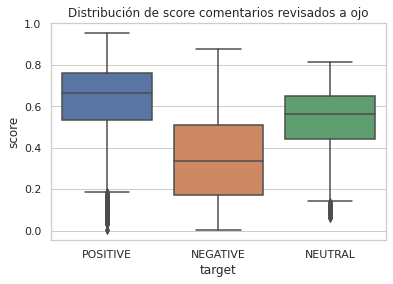

In [182]:
seaborn.boxplot(x='target',
                y='score',
                data = df).set(title ='Distribución de score comentarios revisados a ojo')

La caja de comentarios positivos se encuentra en mayor medida por encima del
score 0,55 a pesar de tener comentarios que el modela clasifica en el rango 0-1. El 75% de los datos está por encima de 0,55

El 75% de los comentarios negativos fueron clasificados por debajo del 0,55

La caja de distribución de comentarios neutrales tiene mayor concentración entre 0,45 y 0,65

Se pueden dejar los neutros en este rango: 0,45-0,65

In [ ]:
#print(comentarios['target'][21]) #muetra clasificación particular
#comentarios['text'][21] #muestra comentarios particular

'Venezuela es el único país donde solicitar la reposición de una tarjeta te dicen que es un favor y no un servicio. Gracias @MercantilBanco'

In [ ]:
#comentarios.loc[comentarios['type']=='post','target']='Nan'#Elimina clasificación de sentimiento de texto de post

## Matriz confusión

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5387 entries, 0 to 5386
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    5387 non-null   int64  
 1   text          5387 non-null   object 
 2   text_process  5387 non-null   object 
 3   true_target   5387 non-null   object 
 4   target        5387 non-null   object 
 5   score         5387 non-null   float64
 6   new_target    5387 non-null   object 
 7   classify      5387 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 336.8+ KB


In [56]:
df.groupby('true_target').count()

,Unnamed: 0,text,text_process,target,score,new_target,classify
true_target,,,,,,,
NEGATIVE,562,562,562,562,562,562,562
NEUTRAL,562,562,562,562,562,562,562
POSITIVE,562,562,562,562,562,562,562


In [57]:
df.reset_index(drop=True,inplace=True)

In [58]:
y_test_1d = list(df1.true_target)
y_pred_1d = list(df1.new_target)

In [59]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

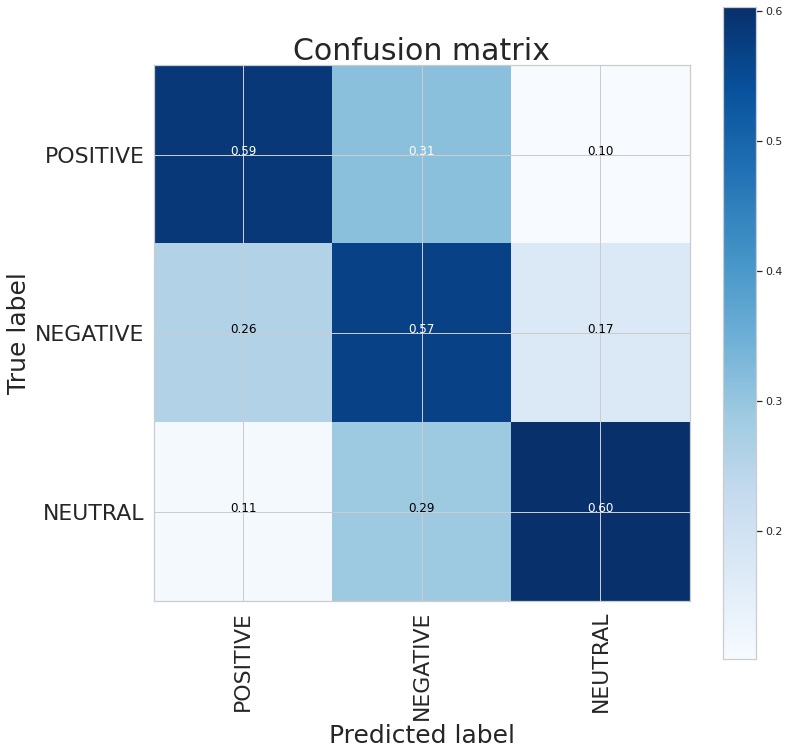

In [60]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df.true_target.unique(), title="Confusion matrix")
plt.show()

In [61]:
acc = accuracy_score(y_test_1d, y_pred_1d)
print(acc)

0.5865954922894425


In [62]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.61      0.59      0.60       562
     NEUTRAL       0.49      0.57      0.53       562
    POSITIVE       0.69      0.60      0.64       562

    accuracy                           0.59      1686
   macro avg       0.60      0.59      0.59      1686
weighted avg       0.60      0.59      0.59      1686



## Guarda excel nuevo

In [ ]:
df.to_excel('/content/drive/MyDrive/Mercantil/Instagram/IG_banescobancouniversalMayo2022.xlsx') #Escribir nombre y ruta de preferencia

In [193]:
df_estudio_neutrosV2.to_excel('/content/drive/MyDrive/Mercantil/data_clasi_a_mano_score_modelV2.xlsx')